In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from support.pd_support import *
from support.omniwheel_calculation import *
from support.imu_calculations import *
from numba import njit
from tqdm import tqdm

Reading mocap and skateboard csv files

In [2]:
# path to files
_parent_folder = "omni_cam_9d0f_may_8_2023"
_folder_name = "sk36_30_random_01"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_cam_9d0f_may_8_2023'

In [3]:
# read encoder data
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  _sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = -_sk_df["e_rl"]

# read mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

Selecting markers

In [4]:
# mocap markers in center of the robot
_xm = get_rb_marker_name(6)
_ym = get_rb_marker_name(4)
_om = get_rb_marker_name(8)

In [5]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org))

calculating coordinates

In [7]:
# for skateboard
y = (19.7/2)/100 # meters
x = 18.5/200 # meters
radius = 5.8/200 # meters

rmat = np.array([[np.cos(np.pi), -np.sin(np.pi), 0],
                [np.sin(np.pi), np.cos(np.pi), 0],
                [0, 0, 1]])

_sk_df = _sk_df
_sk_df = set_zero(_sk_df)
_sk_df, ang_col = get_angular_velocity(_sk_df, ang_per_increment=0.15, del_t=0.01)

_sk_df, vel_col = get_directional_velocity(_sk_df, ang_col, radius=radius, x = x, y = y, rmat=rmat)
_sk_df, col_names = get_position(_sk_df)
_sk_df, _ang_name = get_orientation(_sk_df)


"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

"""mocap in skateboard frame of reference"""

_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    # _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    _x, _y, _z = (rmat @ apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)).T[0]
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 5860/5860 [00:02<00:00, 2505.04it/s]


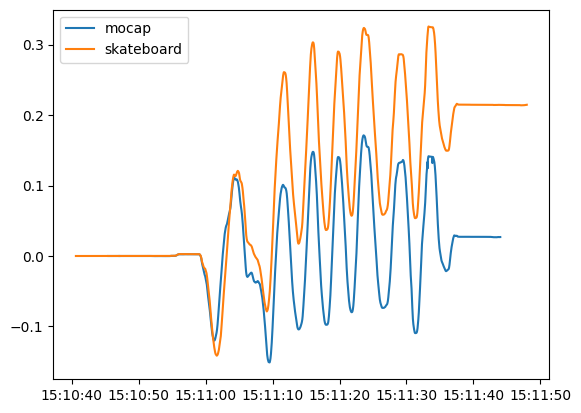

In [8]:
plt.plot(_mc_df["time"], _mc_df["x"], label="mocap")
plt.plot(_sk_df["time"], _sk_df["x"], label="skateboard")
plt.legend()
plt.show()